# 패키지 설치


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyLDAvis
!pip install selenium
!pip install selenium
!pip install BeautifulSoup4
!apt update
!apt install chromium-chromedriver

#Install Mecab

In [3]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 72 (delta 31), reused 20 (delta 5), pack-reused 0
Unpacking objects: 100% (72/72), done.


In [4]:
cd Mecab-ko-for-Google-Colab

/content/Mecab-ko-for-Google-Colab


In [ ]:
!bash install_mecab-ko_on_colab190912.sh

In [6]:
cd /content/mecab-ko-dic-2.1.1-20180720

/content/mecab-ko-dic-2.1.1-20180720


In [7]:
ls user-dic

nnp.csv  person.csv  place.csv  README.md


In [8]:
cp "/content/drive/My Drive/GitHub/2020-2-OSSP1-WhatsUp-5/text_mining/data/nnp.csv" "./user-dic/nnp.csv"

In [9]:
# 정상적으로 DRIVE에서 COPY 되었는지 확인
with open("./user-dic/nnp.csv", 'r', encoding='utf-8') as f: 
    file_new = f.readlines() 
#file_new

In [10]:
ls tools

add-userdic.sh*  convert_for_using_store.sh*  mecab-bestn.sh*


In [ ]:
!bash ./tools/add-userdic.sh

In [12]:
!make install

make[1]: Entering directory '/content/mecab-ko-dic-2.1.1-20180720'
make[1]: Nothing to be done for 'install-exec-am'.
 /bin/mkdir -p '/usr/local/lib/mecab/dic/mecab-ko-dic'
 /usr/bin/install -c -m 644 model.bin matrix.bin char.bin sys.dic unk.dic left-id.def right-id.def rewrite.def pos-id.def dicrc '/usr/local/lib/mecab/dic/mecab-ko-dic'
make[1]: Leaving directory '/content/mecab-ko-dic-2.1.1-20180720'


#Install Java

In [13]:
cd /content

/content


In [14]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.9.1" 2020-11-04
OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


#Install Mallet

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [16]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim import similarities


# spacy for lemmatization
import spacy
 
# Plotting tools
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
 
 
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
 
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import os.path
import re
import glob

import nltk
nltk.download('stopwords')

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data Load


In [18]:
cd "/content/drive/My Drive/GitHub/2020-2-OSSP1-WhatsUp-5/text_mining"

/content/drive/My Drive/GitHub/2020-2-OSSP1-WhatsUp-5/text_mining


In [19]:
from konlpy.tag import Mecab
import pandas as pd
from tqdm import tqdm

In [20]:
from health_chosun_crawling import get_article

In [21]:
def get_stopword(path="data/stopword.txt"):
    '''
    path : Stop Word path
    return : set

    Generate a set of stop words by reading texts in the path
    '''
    f = open(path, encoding="utf-8")
    stopword = []
    lines = f.readlines()
    for line in lines:
        stopword.append(line.split()[0])
    stopword = set(stopword)
    
    f.close()
    return stopword

In [22]:
def df_to_dic(df):
    dic = {}
    for idx in range(len(df)):
        disease = df.loc[idx, 'disease']
        syn_list = df.loc[idx, 'syn'].split(',')
        for syn in syn_list:
            dic[syn] = disease
    return dic

In [23]:
def to_syn(noun, dic):
    syn = dic.get(noun)
    if syn:
        return syn
    return noun

In [24]:
def preprocess(nouns, stopword, dic):
    '''
    nouns : list type, list of words
    stopword : set type, stopword
    dic : dict type, for synonym processing
    return : list type, nouns after preprocess
    '''
    preprocess_nouns = []
    additional_word = ('암') # 사용하는 단어
    for noun in nouns:
        if (noun in additional_word) or (len(noun) > 1 and (noun not in stopword)):
            noun = to_syn(noun, dic)
            preprocess_nouns.append(noun)
    return preprocess_nouns

In [25]:
def get_nouns_from_csv(data, stopword, synonym):
    '''
    requirement : pandas, mecab
    data : dataframe type, content of article
    stopword : set type, stopword
    synonym : dict type, use in function preprocess
    return : word_list
    
    입력받은 path에서 csv 파일을 읽어와 dataframe에 저장
    'text' col을 차례대로 Mecab을 이용해 형태소 분석하여 명사만 word_list에 추가
    '''  
    mecab = Mecab()     # 형태소분석기 Mecab(사용자정의사전 추가)
    word_list = []
        
    for idx in tqdm(range(len(data))):
        try:
            nouns = mecab.nouns(data.loc[idx, 'content'])
            nouns = preprocess(nouns=nouns, stopword=stopword, dic=synonym)
            word_list.append(nouns)
        except Exception as e:
            continue
    print("\nNoun Extraction Complete")

    return word_list

In [26]:
# Load Data
# data = get_article()
data = pd.read_csv("data/article.csv", encoding="utf-8")
stopword = get_stopword()
df = pd.read_csv("data/disease_list.csv", encoding="utf-8")
synonym = df_to_dic(df=df)

# load article data and extract nouns
word_list = get_nouns_from_csv(data=data, stopword=stopword, synonym=synonym)

100%|██████████| 1014/1014 [00:02<00:00, 364.68it/s]


Noun Extraction Complete


In [ ]:
word_list

진행
# 새 섹션

In [28]:
# create Dictionary
id2word=corpora.Dictionary(word_list)
id2word.filter_extremes(no_below=20)

# create Corpus
texts = word_list

# Term Document Frequency
corpus=[id2word.doc2bow(text) for text in texts]

## Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [39]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [42]:
#최적의 토픽 수를 찾기 위해 여러 토픽 수로 일관성을 계산하고 비교
def compute_coherence_values(mallet_path, id2word, corpus, texts, limit, start=8, step=2,):
    coherence_values = []
    model_list = []
    topic_cnt = 0

    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    for idx, value in enumerate(coherence_values[1:]):
        if coherence_values[topic_cnt] < value:
            topic_cnt = idx
        else:
            break

    return model_list, coherence_values, topic_cnt

In [45]:
model_list, coherence_values, topic_idx = compute_coherence_values(mallet_path=mallet_path ,id2word=id2word, 
                                                        corpus=corpus, texts=texts, 
                                                        start=6, limit=31, step=3)


100%|██████████| 9/9 [06:07<00:00, 40.88s/it]


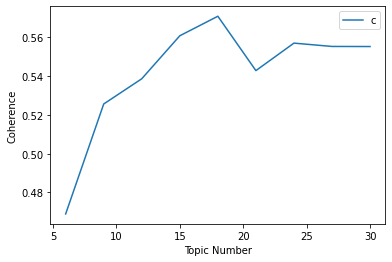

In [46]:
# 일관성 점수 그래프 보기
limit=31; start=6; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Topic Number")
plt.ylabel("Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [47]:
ldamallet = model_list[topic_idx]

In [48]:
pprint(ldamallet.show_topics(formatted=False))

[(6,
  [('사용', 0.0790820538220241),
   ('피부', 0.0554730064388311),
   ('소변', 0.021627868581806174),
   ('세균', 0.02047218094766386),
   ('노출', 0.018160805679379232),
   ('주의', 0.017995707445930327),
   ('건조', 0.01717021627868582),
   ('제거', 0.01667492157833911),
   ('구강', 0.015354135710747894),
   ('자극', 0.015189037477298993)]),
 (8,
  [('섭취', 0.05252347417840376),
   ('음식', 0.046801643192488265),
   ('지방', 0.04401408450704225),
   ('비타민', 0.03491784037558685),
   ('건강', 0.03198356807511737),
   ('도움', 0.030663145539906102),
   ('식품', 0.030369718309859156),
   ('단백질', 0.029049295774647887),
   ('식사', 0.02523474178403756),
   ('성분', 0.021566901408450703)]),
 (14,
  [('여성', 0.07222739981360671),
   ('증가', 0.05871388630009319),
   ('남성', 0.04488971730351041),
   ('정상', 0.037899968934451696),
   ('기능', 0.034482758620689655),
   ('호르몬', 0.033550792171481825),
   ('감소', 0.02842497670083877),
   ('이상', 0.02764833799316558),
   ('영향', 0.02267785026405716),
   ('건강', 0.021590556073314695)]),
 (9

In [49]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5607774051580705


In [50]:
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
3     -0.000295  0.000246       1        1  8.772670
10    -0.000603  0.000343       2        1  7.753259
7      0.001270  0.000190       3        1  7.555112
2     -0.000817  0.000031       4        1  7.295054
5      0.000103  0.000327       5        1  6.991156
4     -0.000069  0.000044       6        1  6.913238
0     -0.000041  0.000757       7        1  6.898532
13    -0.000328 -0.000779       8        1  6.739386
8     -0.000201 -0.000312       9        1  6.575152
14     0.000304 -0.000606      10        1  6.451643
1      0.000249  0.000621      11        1  6.289509
9     -0.000099  0.000425      12        1  6.263950
6      0.000489 -0.000248      13        1  5.837610
12    -0.000344 -0.000461      14        1  5.400590
11     0.000381 -0.000579      15        1  4.263139, topic_info=    Term        Freq       Total Category  logprob  loglift
185   체내  109.000000  109.000000  Default  30.0000  30.0000
636  의료진  112.000000  112.000000  Default  29.0000  29.0000
631   발현  108.000000  108.000000  Default  28.0000  28.0000
884   혈류  109.000000  109.000000  Default  27.0000  27.0000
797   남녀  107.000000  107.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
290   전망    5.610915  113.391343  Topic15  -6.6379   0.1490
751   척추    5.609926  113.516227  Topic15  -6.6380   0.1478
60    저하    5.631430  114.812813  Topic15  -6.6342   0.1402
385  면역력    5.537470  110.983837  Topic15  -6.6510   0.1573
384   면역    5.560007  116.738783  Topic15  -6.6470   0.1108

[593 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.081119   가능
0         2  0.081119   가능
0         3  0.072105   가능
0         4  0.081119   가능
0         5  0.072105   가능
...     ...       ...  ...
513      11  0.062785   흡연
513      12  0.062785   흡연
513      13  0.062785   흡연
513      14  0.053816   흡연
513      15  0.044847   흡연

[6810 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 11, 8, 3, 6, 5, 1, 14, 9, 15, 2, 10, 7, 13, 12])

In [51]:
#트윗들의 토픽을 확인 (토픽별로)
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=texts):
    sent_topics_df = pd.DataFrame()

    #ldamodel[corpus]: lda_model에 corpus를 넣어 각 토픽 당 확률을 알 수 있음
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = ldamodel.show_topic(topic_num,topn=20)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=texts)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


df_dominant_topic=df_dominant_topic.sort_values(by=['Dominant_Topic'])
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
592,592,0.0,0.4764,"코로나-19, 백신, 감염, 독감, 예방, 접종, 바이러스, 사망, 사례, 이상, ...","[인천, 청소년, 전북, 고창, 대전, 제주, 대구, 독감, 독감, 백신, 접종, ..."
576,576,0.0,0.2754,"코로나-19, 백신, 감염, 독감, 예방, 접종, 바이러스, 사망, 사례, 이상, ...","[독감, 백신, 접종, 이후, 사망, 사례, 가운데, 경북, 성주, 경남, 창원, ..."
580,580,0.0,0.3430,"코로나-19, 백신, 감염, 독감, 예방, 접종, 바이러스, 사망, 사례, 이상, ...","[코로나-19, 시대, 독감, 누가, 위험, 코로나-19, 시대, 고령자, 독감, ..."
581,581,0.0,0.3599,"코로나-19, 백신, 감염, 독감, 예방, 접종, 바이러스, 사망, 사례, 이상, ...","[코로나-19, 시국, 백신, 개발, 최근, 저명, 국제, 학술지, 네이처, 메디신..."
700,700,0.0,0.1893,"코로나-19, 백신, 감염, 독감, 예방, 접종, 바이러스, 사망, 사례, 이상, ...","[오늘, 세계, 유엔, 총회, 제정, 감염, 질환, 고통, 세계, 어린이, 팬데, ..."
...,...,...,...,...,...
874,874,14.0,0.2830,"여성, 증가, 남성, 정상, 기능, 호르몬, 감소, 이상, 영향, 건강, 변화, 아...","[여성, 누구, 청소년기, 성징, 생리, 시작, 폐경, 평균, 생리, 지속, 현상,..."
448,448,14.0,0.2009,"여성, 증가, 남성, 정상, 기능, 호르몬, 감소, 이상, 영향, 건강, 변화, 아...","[코로나-19, 이후, 마스크, 착용, 개인, 방역, 강화, 호흡기, 감염, 질환,..."
300,300,14.0,0.2231,"여성, 증가, 남성, 정상, 기능, 호르몬, 감소, 이상, 영향, 건강, 변화, 아...","[북한, 여성, 피임, 만기 정상 분만, 장려, 정책, 식량난, 경제난, 자녀, 양..."
260,260,14.0,0.3378,"여성, 증가, 남성, 정상, 기능, 호르몬, 감소, 이상, 영향, 건강, 변화, 아...","[최근, 외모, 남성, 증가, 탈모, 치료, 관심, 탈모증, 가운데, 탈모, 유형,..."


In [56]:
# 각 토픽에서 가장 대표적인 문장 찾기
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)


sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)


topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts.sort_index(inplace=True)

topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_contribution

lda_inform = pd.concat([sent_topics_sorteddf_mallet, topic_counts, topic_contribution], axis=1)
lda_inform.columns=["Topic_Num", "Topic_Perc_Contrib", "Keywords", "Text", "Num_Documents", "Perc_Documents"]


lda_inform

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Num_Documents,Perc_Documents
0.0,0.0,0.5459,"코로나-19, 백신, 감염, 독감, 예방, 접종, 바이러스, 사망, 사례, 이상","[올해, 독감, 예방, 접종, 이상, 반응, 신고, 건수, 사망, 사례, 포함, 인...",76,0.0810
1.0,1.0,0.6467,"마스크, 관리, 착용, 이상, 국민, 단계, 시설, 방역, 의원, 보건","[오늘, 전국, 거리, 단계, 단계, 완화, 중순, 서울, 신생아 경련, 지역, 단...",53,0.0565
2.0,2.0,0.5036,"질환, 당뇨병, 위험, 혈관, 혈액, 환자, 심장, 뇌졸중, 이상, 혈압","[세계, 당뇨병, 당뇨병, 당뇨병, 환자, 급증, 유병, 기간, 심혈, 질환, 합병...",58,0.0618
3.0,3.0,0.5446,"치료, 환자, 수술, 암, 발생, 가능, 시행, 병원, 교수, 진단","[나라, 발생, 암, 위암, 국가, 암, 정보, 센터, 발생, 암, 기록, 위암, ...",62,0.0661
4.0,4.0,0.3638,"연구, 결과, 분석, 교수, 위험, 그룹, 미국, 대상, 최근, 조사","[혈액형, 코로나-19, 비율, 중증, 반면, 코로나-19, 비율, 중증, 연구, ...",79,0.0842
5.0,5.0,0.5372,"운동, 통증, 근육, 관절, 허리, 척추, 다리, 자세, 무릎, 상태","[엉덩이, 근육, 단련, 쿼트, 런지, 운동, 운동, 엉덩이, 허벅지, 운동, 엉덩...",95,0.1013
6.0,6.0,0.5064,"사용, 피부, 소변, 세균, 노출, 주의, 건조, 제거, 구강, 자극","[샤워, 습관, 피부, 건강, 위협, 피부, 악영향, 잘못, 샤워, 습관, 샤워기,...",62,0.0661
7.0,7.0,0.6246,"개발, 임상, 치료제, 바이오, 진단, 생산, 국내, 미국, 제품, 시험","[식품, 품안, 전처, 연내, 신속, 심사, 대상, 약품, 추가, 지정, 계획, 항...",78,0.0832
8.0,8.0,0.5506,"섭취, 음식, 지방, 비타민, 건강, 도움, 식품, 단백질, 식사, 성분","[코로나-19, 시대, 강조, 영양소, 단백질, 단백질, 근육, 구성, 면역, 세포...",92,0.0981
9.0,9.0,0.4099,"건강, 장애, 스트레스, 수면, 생활, 신경, 우울증, 활동, 치아, 방법","[고령, 코앞, 노인, 정신, 건강, 빨간불, 치매, 치매, 환자, 주변인, 고통,...",65,0.0693


In [67]:
# 각 Document의 topic

def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=texts):
# Init output
    sent_topics_df = pd.DataFrame()
 
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
 
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
 
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=texts)
 
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No.', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
 
# Show
df_dominant_topic.head(10)

,Document_No.,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.3802,"건강, 장애, 스트레스, 수면, 생활, 신경, 우울증, 활동, 치아, 방법","[우울증, 주요, 증상, 우울, 기분, 저하, 식욕, 감퇴, 우울증, 증세, 노인,..."
1,1,3.0,0.2731,"치료, 환자, 수술, 암, 발생, 가능, 시행, 병원, 교수, 진단","[대동맥, 혈관, 온몸, 장기, 혈액, 고속도로, 대동맥, 직경, 확장, 증상, 수..."
2,2,12.0,0.1982,"효과, 염증, 세포, 대사, 면역, 복용, 실제, 물질, 환자, 개선","[피부, 건강, 운동, 실제, 운동, 피부, 과학, 근거, 운동, 체내, 염증, 염..."
3,3,0.0,0.1781,"코로나-19, 백신, 감염, 독감, 예방, 접종, 바이러스, 사망, 사례, 이상","[코로나-19, 독감, 독감, 동시, 진단, 유전자, 증폭, 검사, 건강, 보험, ..."
4,4,14.0,0.3229,"여성, 증가, 남성, 정상, 기능, 호르몬, 감소, 이상, 영향, 건강","[코로나-19, 유행, 연말, 건강검진, 쏠림, 현상, 건강검진, 기간, 한시, 연..."
5,5,8.0,0.2396,"섭취, 음식, 지방, 비타민, 건강, 도움, 식품, 단백질, 식사, 성분","[당뇨병, 환자, 방심, 공격, 음식, 음식, 당뇨병, 환자, 노력, 짠맛, 증명,..."
6,6,7.0,0.3885,"개발, 임상, 치료제, 바이오, 진단, 생산, 국내, 미국, 제품, 시험","[삼성, 바이오, 로직스, 인천, 송도, 글로벌, 캠퍼스, 공장, 착공식, 개최, ..."
7,7,7.0,0.3815,"개발, 임상, 치료제, 바이오, 진단, 생산, 국내, 미국, 제품, 시험","[보령, 제약, 식품, 품안, 전처, 예산, 공장, 항암, 주사제, 생산, 시설, ..."
8,8,5.0,0.3809,"운동, 통증, 근육, 관절, 허리, 척추, 다리, 자세, 무릎, 상태","[근육, 허벅지, 가슴, 근육, 근육, 건강, 영향, 근육, 저하, 목욕, 화장실,..."
9,9,0.0,0.3709,"코로나-19, 백신, 감염, 독감, 예방, 접종, 바이러스, 사망, 사례, 이상","[독감, 환자, 통상, 증가, 시작, 발생, 올해, 코로나-19, 독감, 동시, 감..."


In [69]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()
 
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
 
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
        grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
        axis=0)
 
# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
 
# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
 
# Show
sent_topics_sorteddf_mallet.head(5)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5459,"코로나-19, 백신, 감염, 독감, 예방, 접종, 바이러스, 사망, 사례, 이상","[올해, 독감, 예방, 접종, 이상, 반응, 신고, 건수, 사망, 사례, 포함, 인..."
1,1.0,0.6467,"마스크, 관리, 착용, 이상, 국민, 단계, 시설, 방역, 의원, 보건","[오늘, 전국, 거리, 단계, 단계, 완화, 중순, 서울, 신생아 경련, 지역, 단..."
2,2.0,0.5036,"질환, 당뇨병, 위험, 혈관, 혈액, 환자, 심장, 뇌졸중, 이상, 혈압","[세계, 당뇨병, 당뇨병, 당뇨병, 환자, 급증, 유병, 기간, 심혈, 질환, 합병..."
3,3.0,0.5446,"치료, 환자, 수술, 암, 발생, 가능, 시행, 병원, 교수, 진단","[나라, 발생, 암, 위암, 국가, 암, 정보, 센터, 발생, 암, 기록, 위암, ..."
4,4.0,0.3638,"연구, 결과, 분석, 교수, 위험, 그룹, 미국, 대상, 최근, 조사","[혈액형, 코로나-19, 비율, 중증, 반면, 코로나-19, 비율, 중증, 연구, ..."


In [58]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
 
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
 
# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
 
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
 
# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']
 
# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,9.0,"건강, 장애, 스트레스, 수면, 생활, 신경, 우울증, 활동, 치아, 방법",76.0,0.0810
1.0,3.0,"치료, 환자, 수술, 암, 발생, 가능, 시행, 병원, 교수, 진단",53.0,0.0565
2.0,12.0,"효과, 염증, 세포, 대사, 면역, 복용, 실제, 물질, 환자, 개선",58.0,0.0618
3.0,0.0,"코로나-19, 백신, 감염, 독감, 예방, 접종, 바이러스, 사망, 사례, 이상",62.0,0.0661
4.0,14.0,"여성, 증가, 남성, 정상, 기능, 호르몬, 감소, 이상, 영향, 건강",79.0,0.0842
...,...,...,...,...
933.0,10.0,"증상, 질환, 원인, 검사, 발생, 치료, 이상, 신경, 의심, 진단",NaN,NaN
934.0,14.0,"여성, 증가, 남성, 정상, 기능, 호르몬, 감소, 이상, 영향, 건강",NaN,NaN
935.0,2.0,"질환, 당뇨병, 위험, 혈관, 혈액, 환자, 심장, 뇌졸중, 이상, 혈압",NaN,NaN
936.0,8.0,"섭취, 음식, 지방, 비타민, 건강, 도움, 식품, 단백질, 식사, 성분",NaN,NaN
